In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr30k/captions.txt
/kaggle/input/flickr30k/Images/2715746315.jpg
/kaggle/input/flickr30k/Images/3463034205.jpg
/kaggle/input/flickr30k/Images/268704620.jpg
/kaggle/input/flickr30k/Images/2673564214.jpg
/kaggle/input/flickr30k/Images/7535037918.jpg
/kaggle/input/flickr30k/Images/4912369161.jpg
/kaggle/input/flickr30k/Images/4828071602.jpg
/kaggle/input/flickr30k/Images/6802728196.jpg
/kaggle/input/flickr30k/Images/3346289227.jpg
/kaggle/input/flickr30k/Images/3217056901.jpg
/kaggle/input/flickr30k/Images/272471327.jpg
/kaggle/input/flickr30k/Images/4717261252.jpg
/kaggle/input/flickr30k/Images/4763916790.jpg
/kaggle/input/flickr30k/Images/2700788458.jpg
/kaggle/input/flickr30k/Images/2795287622.jpg
/kaggle/input/flickr30k/Images/4453893059.jpg
/kaggle/input/flickr30k/Images/2094323311.jpg
/kaggle/input/flickr30k/Images/2375770917.jpg
/kaggle/input/flickr30k/Images/5962278982.jpg
/kaggle/input/flickr30k/Images/2460568004.jpg
/kaggle/input/flickr30k/Images/2567962271.jpg

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
Data_location = '/kaggle/input/flickr30k/Images/flickr30k_images'
Data_save = '/kaggle/working/'

In [4]:
model = VGG16()
#Restructuring the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#Summary of the model
print(model.summary())

553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [8]:
features = {}
directory = os.path.join(Data_location)

for img_name in tqdm(os.listdir(directory)):
    #Loading the images
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    #Converting image pixels to numpy array
    image = img_to_array(image)
    #Reshaping data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #Preprocessing the images for vgg
    image = preprocess_input(image)
    #Extracting features of the images
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    
    #Storing the features
    features[image_id] = feature

  0%|          | 0/31783 [00:00<?, ?it/s]

In [10]:
pickle.dump(features, open(os.path.join(Data_save, 'features.pkl'), 'wb'))

In [11]:
#Loading saved features from pickle
with open(os.path.join(Data_save, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [13]:
Data_location = '/kaggle/input/flickr30k'

In [14]:
#Loading the captions
with open(os.path.join(Data_location, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [15]:
#Mapping the images to captions
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    #Removing extension from image ID
    image_id = image_id.split('.')[0]
    #Converting caption list to string
    caption = " ".join(caption)
    #Create a list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    #Storing the caption
    mapping[image_id].append(caption)

  0%|          | 0/158916 [00:00<?, ?it/s]

In [16]:
len(mapping)

31783

In [17]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            #Converting to lowercase
            caption = caption.lower()
            #Deleting digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            #Deleting additional spaces
            caption = caption.replace('\s+', ' ')
            #Adding start and end tags to the caption
            caption = 'sos ' + " ".join([word for word in caption.split() if len(word)>1]) + ' eos'
            captions[i] = caption

In [30]:
#Before preprocessing of text
mapping['1000092795']

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes ." endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [31]:
clean(mapping)

In [32]:
#After preprocessing of text
mapping['1000092795']

['sos startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq eos',
 'sos startseq two young white males are outside near many bushes ." endseq eos',
 'sos startseq two men in green shirts are standing in yard endseq eos',
 'sos startseq man in blue shirt standing in garden endseq eos',
 'sos startseq two friends enjoy time spent together endseq eos']

In [18]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [19]:
len(all_captions)

158915

In [36]:
all_captions[:10]

['sos startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq eos',
 'sos startseq two young white males are outside near many bushes ." endseq eos',
 'sos startseq two men in green shirts are standing in yard endseq eos',
 'sos startseq man in blue shirt standing in garden endseq eos',
 'sos startseq two friends enjoy time spent together endseq eos',
 'sos startseq several men in hard hats are operating giant pulley system endseq eos',
 'sos startseq workers look down from up above on piece of equipment endseq eos',
 'sos startseq two men working on machine wearing hard hats endseq eos',
 'sos startseq four men on top of tall structure endseq eos',
 'sos startseq three men on large rig endseq eos']

In [20]:
#Tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [21]:
vocab_size

18314

In [22]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

80

In [23]:
#Splitting the images into train and test sets
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [24]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            #Processing each caption
            for caption in captions:
                #Encoding
                seq = tokenizer.texts_to_sequences([caption])[0]
                #Splitting into X, y pairs
                for i in range(1, len(seq)):
                    #Splitting into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    #Encoding output sequences
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    #Storing the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [25]:
from keras.layers import Bidirectional

In [31]:
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional, Concatenate, Dot, Reshape
from keras.models import Model

# Assuming you have defined max_length and vocab_size appropriately

# Encoder
inputs1 = Input(shape=(4096,))
if1 = Dropout(0.5)(inputs1)
if2 = Dense(256, activation='relu')(if1)

# Decoder
inputs2 = Input(shape=(max_length,))
sf1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
sf2 = Dropout(0.5)(sf1)
sf3 = LSTM(256, return_sequences=True)(sf2)

# Attention Mechanism
attention = Dot(axes=[2, 1])([sf3, Reshape((256, 1))(if2)])
attention = Dense(max_length, activation='softmax')(attention)
context = Dot(axes=[2, 1])([attention, sf3])

# Decoder (continued)
decoder3 = LSTM(256)(context)

outputs = Dense(vocab_size, activation='softmax')(decoder3)

# Define the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 80)]         0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 4096)]       0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 80, 256)      4688384     ['input_13[0][0]']               
                                                                                                  
 dropout_10 (Dropout)           (None, 4096)         0           ['input_12[0][0]']               
                                                                                            

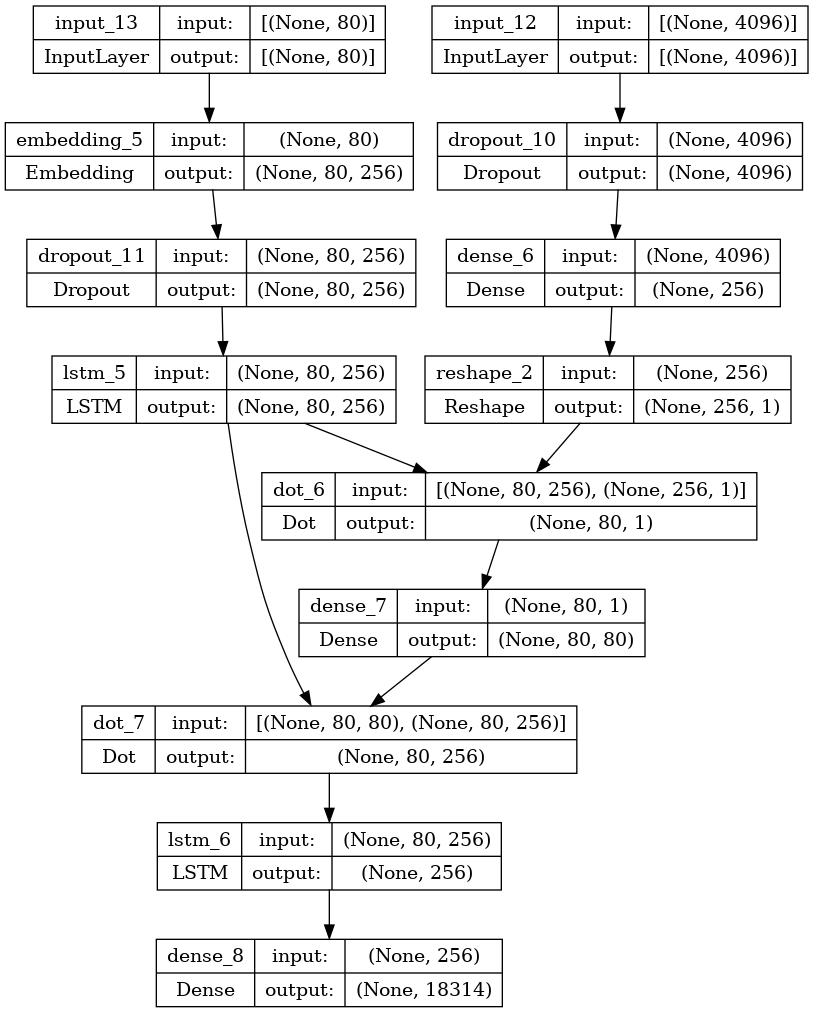

In [32]:
plot_model(model, show_shapes=True)

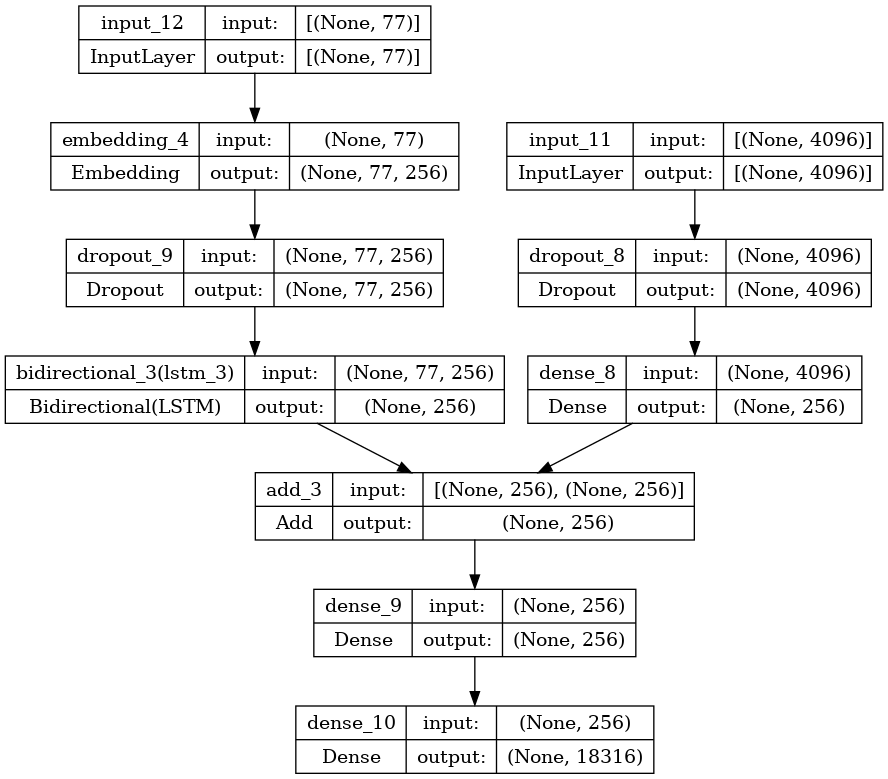

In [49]:
                                                    #Encoder
#Image Feature layers
inputs1 = Input(shape=(4096,))
if1 = Dropout(0.3)(inputs1)
if2 = Dense(256, activation='relu')(if1)

#Sequence feature layers
inputs2 = Input(shape=(max_length,))
sf1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
sf2 = Dropout(0.3)(sf1)
sf3 = Bidirectional(LSTM(128))(sf2)

                                                    #Decoder
decoder1 = add([if2, sf3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = 'accuracy')

plot_model(model, show_shapes=True)
#                                                     #Encoder
# #Image Feature layers
# inputs1 = Input(shape=(4096,))
# if1 = Dropout(0.4)(inputs1)
# if2 = Dense(256, activation='relu')(if1)

# #Sequence feature layers
# inputs2 = Input(shape=(max_length,))
# sf1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
# sf2 = Dropout(0.4)(sf1)
# sf3 = LSTM(256)(sf2)

#                                                     #Decoder
# decoder1 = add([fe2, se3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot_model(model, show_shapes=True)

In [33]:
#Training
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

893/893 [==============================] - 403s 450ms/step - loss: 2.9473 - accuracy: 0.3579


In [34]:
#Saving the model
model.save(Data_save+'/30k_model.h5')

In [35]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [36]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'sos'
    for i in range(max_length):
        #Encoding the input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #Padding the sequence
        sequence = pad_sequences([sequence], max_length)
        #Prediction
        ypred = model.predict([image, sequence], verbose=0)
        #Index with high probability
        ypred = np.argmax(ypred)
        word = idx_to_word(ypred, tokenizer)
        
        if word is None:
            break
       #Append the predicted word
        in_text += " " + word
        #Stopping at the end
        if word == 'eos':
            break
      
    return in_text

In [2]:
from nltk.translate.bleu_score import corpus_bleu
#Checking with the test data
actual, predicted = list(), list()

for key in tqdm(test):
    #Actual Caption
    captions = mapping[key]
    #Predicting the caption
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    actual.append(actual_captions)
    predicted.append(y_pred)
    
#Calculating BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

NameError: name 'test' is not defined

In [63]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    #Loading the image
    image_name = "10002456.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(Data_location, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    #Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
sos startseq several men in hard hats are operating giant pulley system endseq eos
sos startseq workers look down from up above on piece of equipment endseq eos
sos startseq two men working on machine wearing hard hats endseq eos
sos startseq four men on top of tall structure endseq eos
sos startseq three men on large rig endseq eos
--------------------Predicted--------------------
sos startseq man in black shirt and black pants is riding bike endseq eos


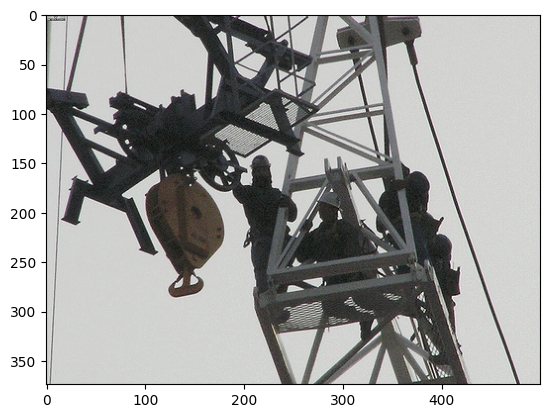

In [64]:
generate_caption("10002456.jpg")